# Análisis compresión de imagenes - tablero ajedrez

## Inicialización de los datos

In [1]:
% matplotlib inline

import pycblosc2 as cb2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycblosc2 as cb2
import time as t
from math import sqrt, log
import heapq

KB = 1024
MB = 1024 * KB
GB = 1024 * MB

BLOSC_MAX_FILTERS = 5
BLOSC_BLOCKSIZE = 16 * KB

cparams = cb2.blosc2_create_cparams(compcode=1, clevel=5, use_dict=0, typesize=4,
                                    nthreads=4, blocksize= 16*KB, schunk=None,
                                    filters=[0, 0, 0, 0, 0],
                                    filters_meta=[0, 0, 0, 0, 0])
dparams = cb2.blosc2_create_dparams(nthreads=1, schunk=None)

image = (plt.imread("../../data/chessg.png")*255).astype(np.uint8)

h = len(image)
w = len(image[0])

div_h = 2 ** np.arange(log(h, 2) + 1, dtype=np.uint32)

div_w = 2 ** np.arange(log(w, 2) + 1, dtype=np.uint32)

#image =  np.pad(image, ((0, 0), (0, 0), (0, 1)), 'constant').view(np.uint32).reshape((w, h))
image = image.view(np.uint32).reshape((w, h))

isize = w * h * image.dtype.itemsize
dsize = 0

## Cálculo y representación de los ratios de compresión

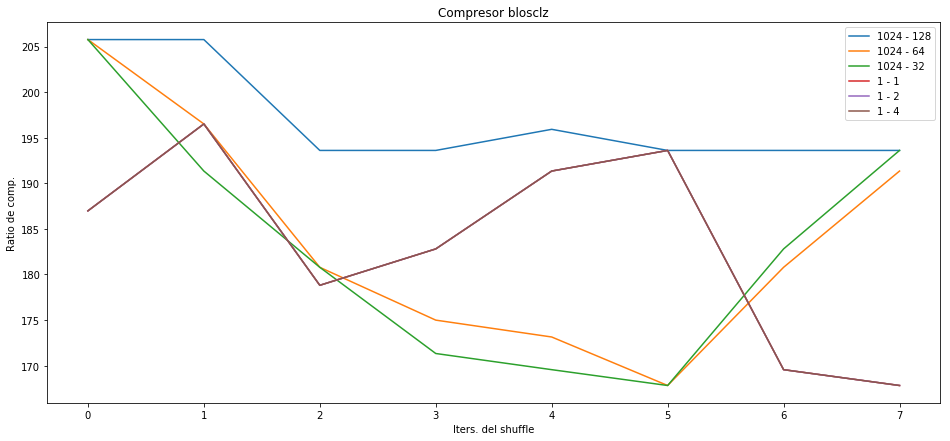

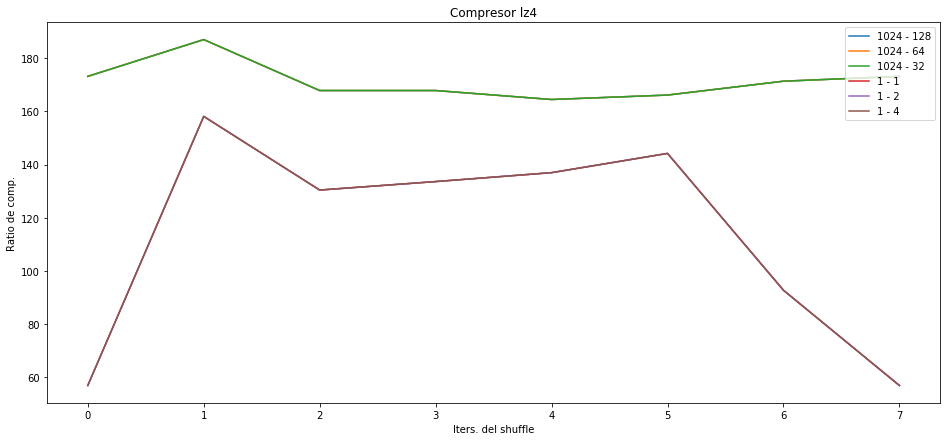

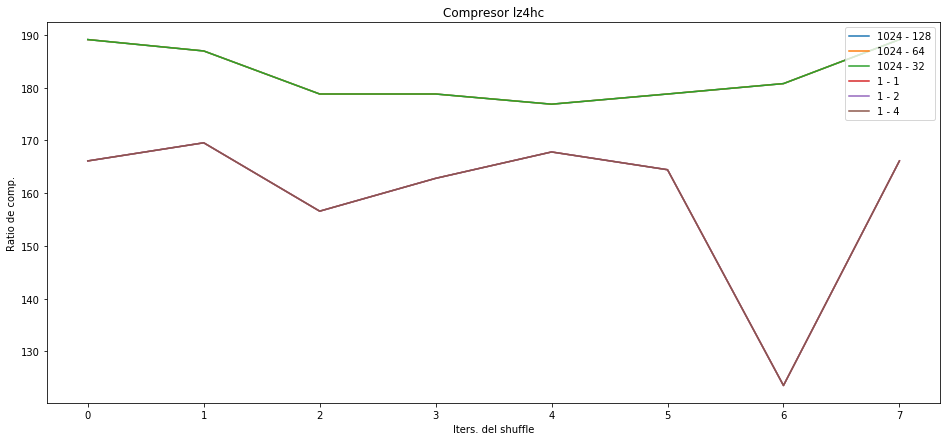

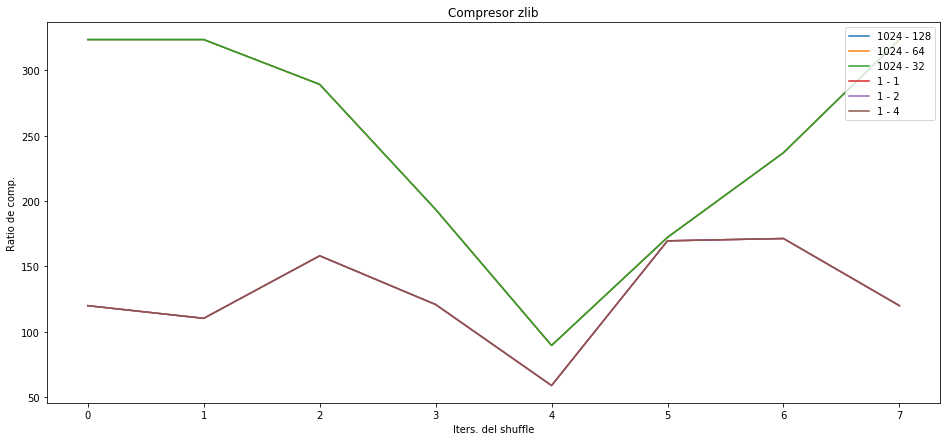

KeyboardInterrupt: 

In [2]:
images_to_plot = []
labels = []

# Calculo de el orden de la permutacion

SIZE = 1024 * 4

TAM_DATA = 4

if  log(SIZE, 2) % log(TAM_DATA, 2) == 0:
    orden = int(log(SIZE, TAM_DATA) + 1)
else:
    orden = int(log(SIZE, 2) + log(TAM_DATA, 2))


# Calculo de los ratios de compresion para cada codec

# max_ratio = [score, dh, dw, iter, compresor]

max_ratio = [0, 0, 0, 0, 0]

for code in [0, 1, 2, 4, 5, 6]:

    fig = plt.figure(figsize=(16, 7))
    
    cparams.compcode = code   
    
    all_ratios = []
    
    for dh in div_h:
         for dw in div_w:
            
            n = []
            ratio = []
            speed = [] 
            
            # Se genera la imagen

            s_image = np.empty((w, h), dtype=np.uint32).flatten()
        
 
            if dh == 1 and dw == 1:
                s_image = image
            
            else:
                cont = 0
                for i in range(h // dh):
                    for j in range(w // dw):
                        s_image[cont*dw*dh:(cont+1)*dw*dh] = image[dh*i:dh*(i+1),dw*j:dw*(j+1)].reshape((1,dw*dh))
                        cont += 1
                        
            if code == 0:
                images_to_plot.append(s_image.reshape(w, h, 1))
                labels.append(str(dh) + " - " + str(dw))

            # Se genera la compresion de la imagen sin shuffle
            
            start = t.perf_counter()  

            cparams.filters[BLOSC_MAX_FILTERS - 1] = 0
            
            schunk = cb2.blosc2_new_schunk(cparams, dparams)
            nchunks = cb2.blosc2_append_buffer(schunk, isize, s_image)
            nbytes = schunk.nbytes
            cbytes = schunk.cbytes
            cb2.blosc2_free_schunk(schunk)

            end = t.perf_counter()

            ttotal = end - start
            r = (1. * nbytes) / cbytes
            s = nbytes / (ttotal * MB)
            n.append(0)
            ratio.append(r)
            speed.append(s)

            #if r > max_ratio[0]:
             #   max_ratio = [r, dh, dw, 0, code]
            
            # Se activa el shuffle

            
            cparams.filters[BLOSC_MAX_FILTERS - 1] = 1

            for s_iter in range(orden):

                # Genera el suffle de la imagen
                
                start = t.perf_counter()   

                cparams.filters_meta[BLOSC_MAX_FILTERS - 1] = s_iter

                schunk = cb2.blosc2_new_schunk(cparams, dparams)
                nchunks = cb2.blosc2_append_buffer(schunk, isize, s_image)
                nbytes = schunk.nbytes
                cbytes = schunk.cbytes
                cb2.blosc2_free_schunk(schunk)

                end = t.perf_counter()

                ttotal = end - start
                r = (1. * nbytes) / cbytes
                s = nbytes / (ttotal * MB)
                n.append(s_iter + 1)
                ratio.append(r)
                speed.append(s)
                
                #if r > max_ratio[0]:
                 #   max_ratio = [r, dh, dw, s_iter + 1, code]
            
            all_ratios.append(ratio)
            
            # plt.plot(n, ratio, label = str(dh) + "-" + str(dw) + " part.")
            
    max_ratios = []
    
    for i in range(len(all_ratios)):
        max_ratios.append((max(all_ratios[i]), i))
    
    top_max_ratios = heapq.nlargest(3, max_ratios)
    tail_max_ratios = heapq.nsmallest(3, max_ratios)
    
    for _, i in top_max_ratios:
        plt.plot(n, all_ratios[i], label = labels[i])
    
    for _, i in tail_max_ratios:
        plt.plot(n, all_ratios[i], label = labels[i])

    plt.ylabel("Ratio de comp.")
    plt.xlabel("Iters. del shuffle")
    plt.title("Compresor " + cb2.blosc_compcode_to_compname(code)[1])
    plt.legend(loc = "upper right")
    plt.show()

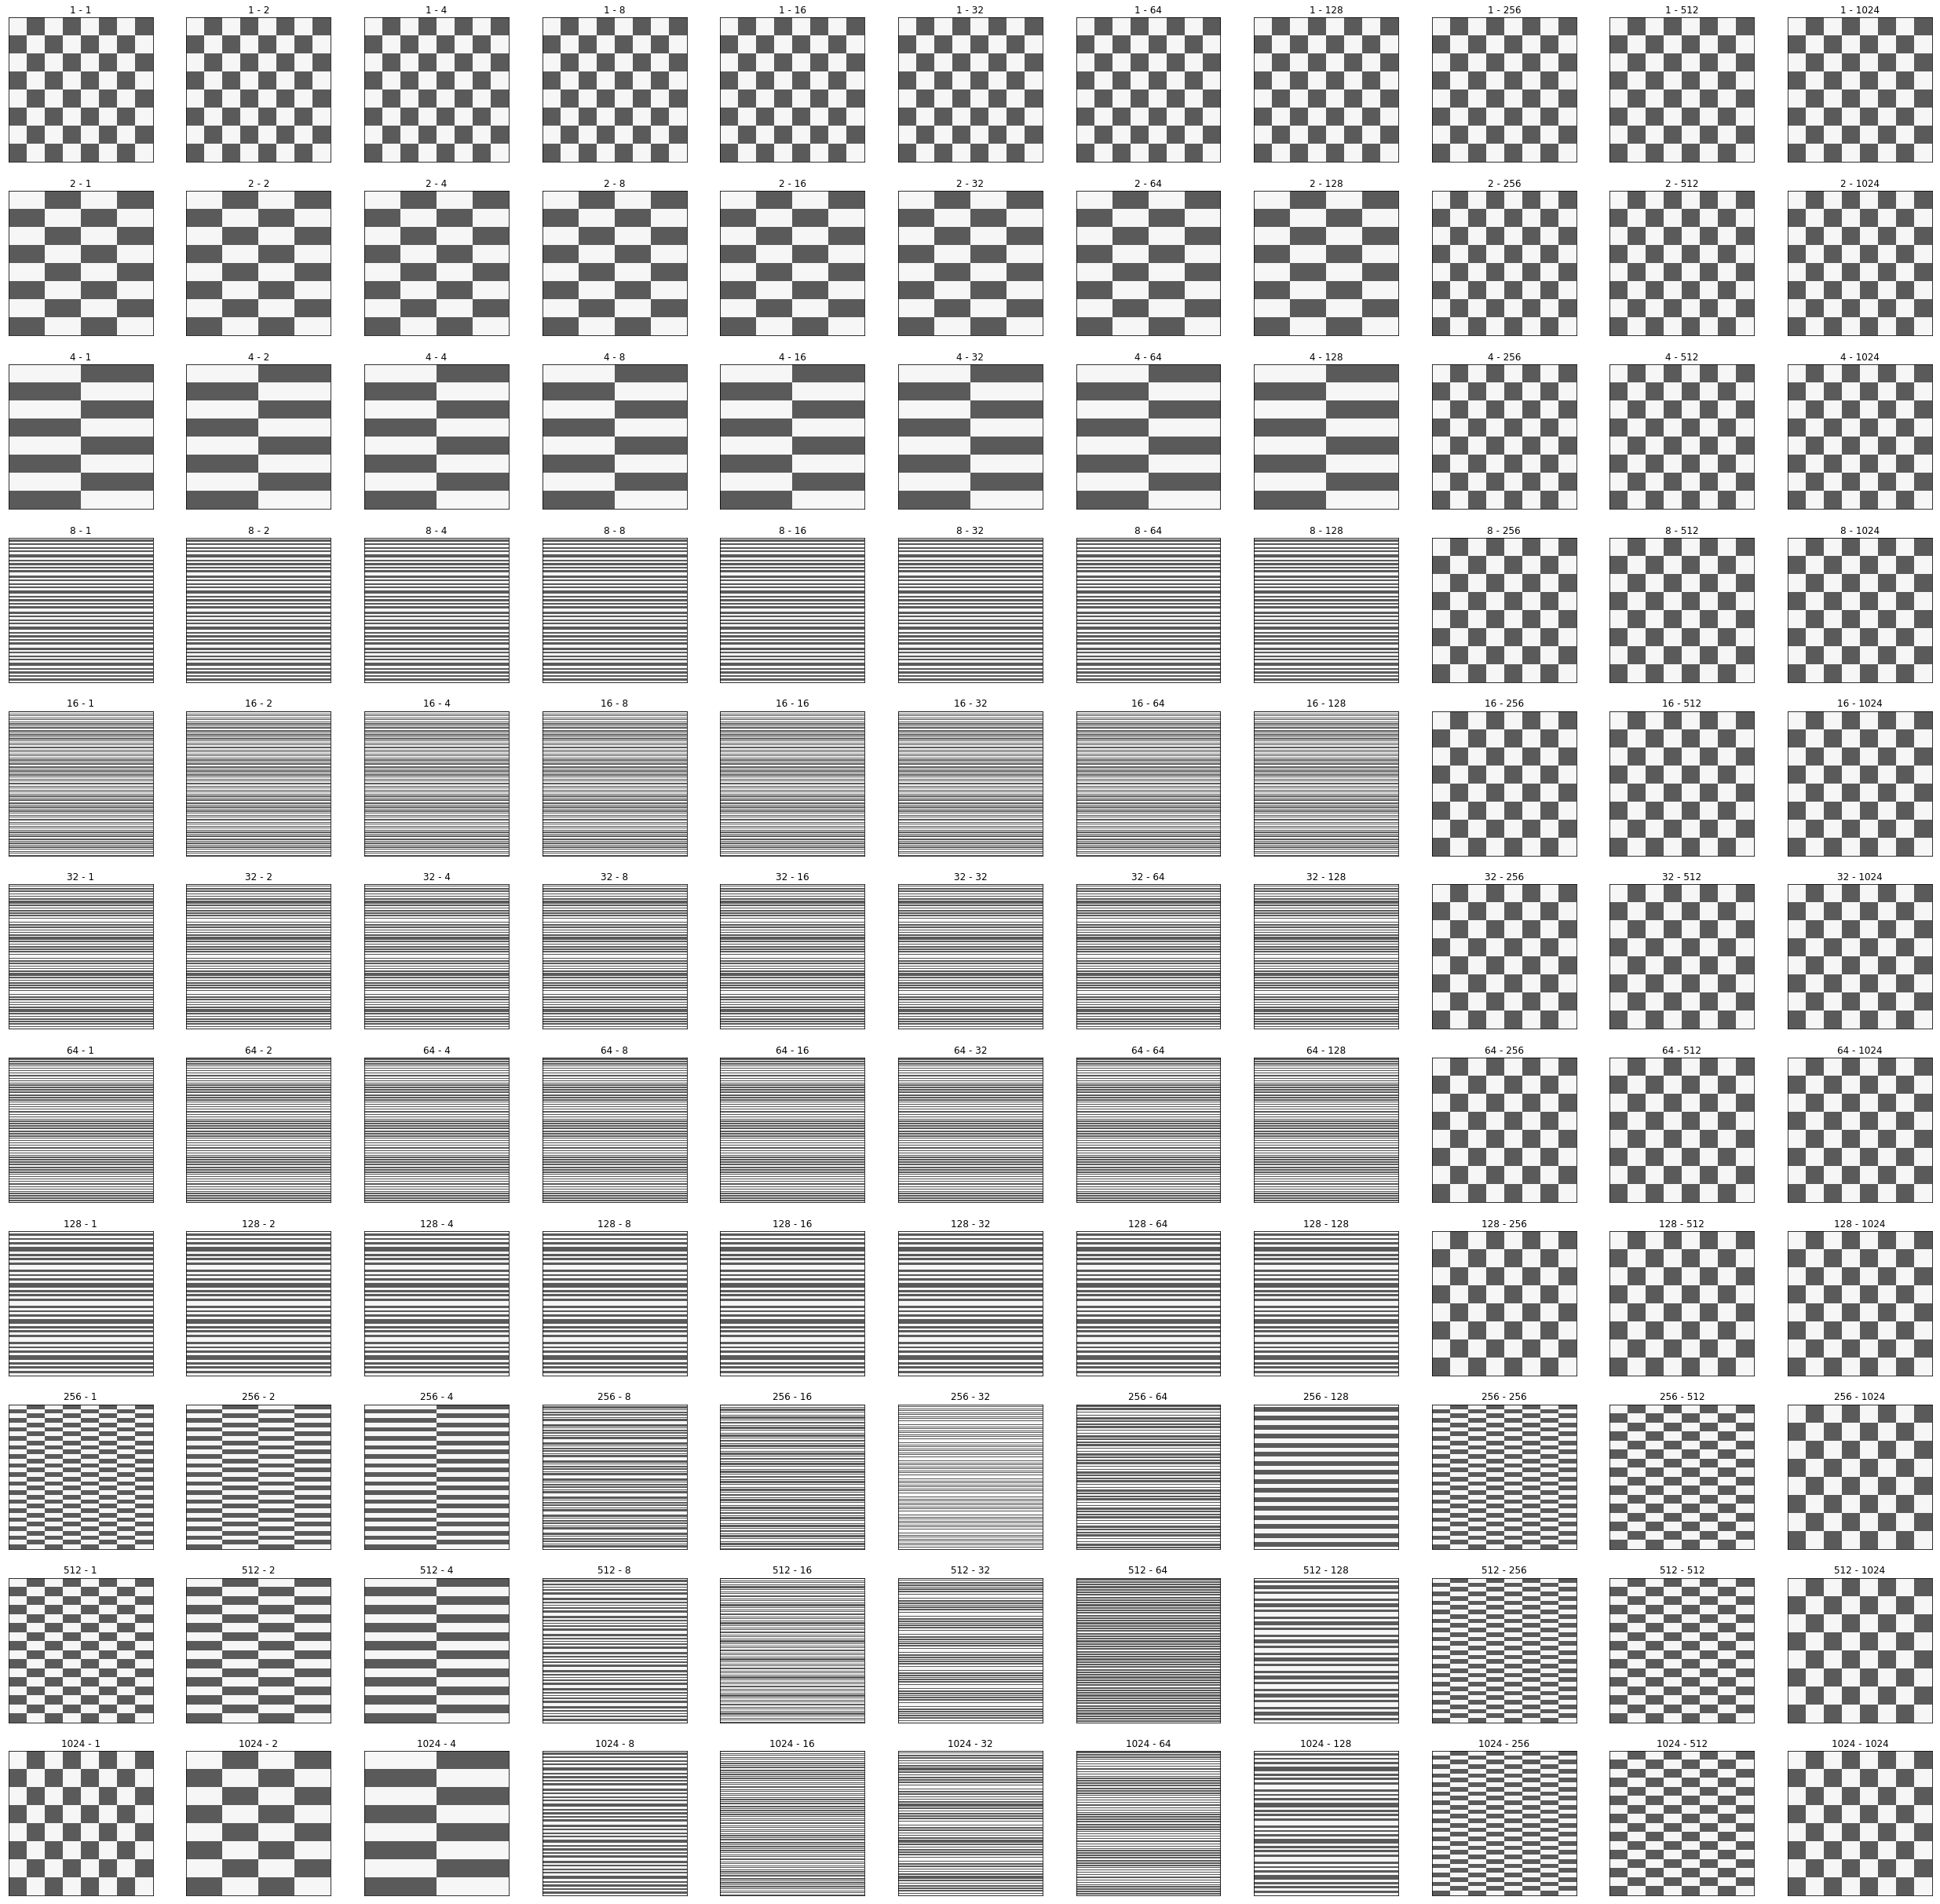

In [7]:
tam = int((sqrt(len(images_to_plot)) - 0.01) // 1) + 1

f, axarr = plt.subplots(tam, tam, figsize=(4*tam,4*tam))

for i, elem in enumerate(images_to_plot):
    axarr[i // tam, i % tam].imshow(elem.view(np.uint8)[:,:,:], cmap='binary')
    axarr[i // tam, i % tam].set_title(labels[i])
    axarr[i // tam, i % tam].xaxis.set_major_locator(plt.NullLocator())
    axarr[i // tam, i % tam].yaxis.set_major_locator(plt.NullLocator())

for i in range(len(images_to_plot), tam * tam):
    axarr[i // tam, i % tam].set_visible(False)
plt.show()